In [18]:
import litellm
litellm._turn_on_debug()
import logging
logging.basicConfig(level=logging.DEBUG, 
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', 
                    handlers=[logging.FileHandler('edgar.log', 'w', 'utf-8')])


logger = logging.getLogger(__name__)


def query_litellm(prompt: str, model_name: str='ollama/hf.co/ernanhughes/Fin-R1-Q8_0-GGUF') -> str:
    """
    Query a LiteLLM-compatible model with a given prompt.

    Args:
        prompt (str): The user's input question.
        model_name (str): The model to use (e.g. 'ollama/qwen2.5' or 'huggingface/your-model').

    Returns:
        str: The model's response text.
    """
    response = litellm.completion(
        model=model_name,
        messages=[{"role": "user", "content": prompt}]
    )

    return response['choices'][0]['message']['content']


In [19]:
from sec_api import QueryApi
from sec_api import ExtractorApi
from dotenv import load_dotenv
import os
load_dotenv()

def get_latest_filing_url(ticker: str, form_type: str = "10-K") -> str:
    api_key = os.getenv("SEC_API_KEY")
    query = {
        "query": {
            "query_string": {
                "query": f"formType:\"{form_type}\" AND ticker:{ticker}"
            }
        },
        "from": "0",
        "size": "20",
        "sort": [{ "filedAt": { "order": "desc" } }]
    }    
    queryApi = QueryApi(api_key=api_key)
    filings = queryApi.get_filings(query)
    accession_number = filings['filings'][0]['accessionNo']
    logger.info(f"Accession number: {accession_number}")    
    cik = filings['filings'][0]['cik']
    logger.info(f"CIK: {cik}")
    url = filings['filings'][0]['linkToHtml']
    return cik, accession_number, url

def get_section_text(filing_url: str, section: str = "1A") -> str:
    """
    Get the text of a specific section from a filing URL.

    Args:All right all right
        filing_url (str): The URL of the filing.
        section (str): The section to extract.

    Returns:
        str: The text of the section.
    """
    api_key = os.getenv("SEC_API_KEY")
    extractorApi = ExtractorApi(api_key)
    text = extractorApi.get_section(filing_url, section, "text")
    return text

# _,_,url = get_latest_filing_url("TSLA")
# print(get_section_text(url, "1A"))

In [20]:
import re
# --- Step 2: Chunk text on paragraphs with approximate size limit ---
def chunk_text(text, chunk_size=20000):
    paragraphs = [p.strip() for p in text.split('\n') if p.strip()]
    chunks = []
    current_chunk = ""
    for para in paragraphs:
        if len(current_chunk) + len(para) <= chunk_size:
            current_chunk += para + "\n"
        else:
            if current_chunk:
                chunks.append(current_chunk.strip())
            current_chunk = para + "\n"
    if current_chunk:
        chunks.append(current_chunk.strip())
    return chunks

In [ ]:

def extract_sentiment_score(text):
    match = re.search(r"Sentiment Score:\s*(?:\*\*)?(\d+(?:\.\d+)?)(?:/10)?(?:\*\*)?", text, re.IGNORECASE)
    res = match.group(1) if match else None
    if res is None: 
        logger.info(f"Error: score not found in {text}")
        return 5
    logger.info(f"sentiment_score: {res}")
    return res if match else None

def extract_sentiment_score_from_tags(text):
    match = re.search(r"<sentiment_score>(\d+(?:\.\d+)?)</sentiment_score>", text, re.IGNORECASE)
    res = match.group(1) if match else None
    if res is None: 
        logger.info(f"Error: score not found in {text}")
        return 5
    return float(match.group(1)) if match else None

def extract_final_summary(text):
    match = re.search(r"Final Summary:\s*(.*?)\n?(Sentiment Score:|</answer>|$)", text, re.DOTALL)
    res = match.group(1).strip() if match else None
    if res is None:
        logger.info(f"Error: final_summary not found in {text}")
        return text
    logger.info(f"final_summary: {res}")
    return res


In [ ]:


# --- Step 3: Perform sentiment analysis using Fin-R1
def analyze_sentiment_with_fin_r1(report_text: str):
    prompt = f"""
You are Fin-R1, a financial language model.
Analyze the following portion of an SEC filing and extract key sentiment and guidance.

<document>
{chunk}
</document>


Respond in Chain-of-Thought format:
- Begin with <think> for detailed reasoning
- Include a long descriptive summary
- End with a clearly labeled section: "Final Summary:" that gives a 1-2 sentence overall summary.
- End with a clearly labeled section:  "Sentiment Score:" from 0 (completely negative) to 10 (completely positive). Surround the score with <sentiment_score> tags.
Wrap everything in <answer> tags.
"""
    content = query_litellm(prompt, model_name='ollama/hf.co/ernanhughes/Fin-R1-Q8_0-GGUF')
    logger.info(f"content: {content}")  
    score = extract_sentiment_score_from_tags(content)
    final_summary = extract_final_summary(content)
    logger.info(f"score: {score}, final_summary: {final_summary}")
    return content, final_summary, score





In [ ]:
# --- Step 4: Summarize all chunk responses ---
def summarize_all_chunks(all_summaries: list):
    combined = "\n\n".join(all_summaries)
    prompt = f"""
You are Fin-R1.
Summarize the overall sentiment and financial outlook from the following collection of analysis outputs from an SEC 10-K filing.
Focus on key trends, risks, tone, and forward-looking statements.

"{combined}"

Respond with a concise <answer> summary followed by optional <insight> sections.
"""
    return query_litellm(prompt, model_name='ollama/hf.co/ernanhughes/Fin-R1-Q8_0-GGUF')


In [24]:
import sqlite3

# --- Step 5: Store EDGAR sentiment results in SQLite ---
conn = sqlite3.connect("edgar_sentiment_results.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS edgar_sentiment (
    cik TEXT,
    accession TEXT,
    sentiment_summary TEXT
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS edgar_sentiment_chunks (
    ticker TEXT,
    cik TEXT,
    accession TEXT,
    chunk_index INTEGER,
    chunk_text TEXT,
    chunk_sentiment TEXT,
    chunk_final_sentiment TEXT,
    sentiment_score REAL
)
""")
conn.commit()


conn.commit()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

results = []
ticker = "TSLA"
form = "10-K" 
chunk_size = 20000
cik, accession_number, url = get_latest_filing_url(ticker, form)
filing_text = get_section_text(url, "1A")

logger.info(f"Processing Filing Text: {filing_text[:100]}...")
if filing_text:
    chunks = chunk_text(filing_text, chunk_size=chunk_size)
    all_summaries = []
    for idx, chunk in enumerate(chunks):
        try:
            content, summary, score = analyze_sentiment_with_fin_r1(chunk)
            all_summaries.append(summary)
            cursor.execute("""
                INSERT INTO edgar_sentiment_chunks (cik, accession, chunk_index, chunk_text, chunk_sentiment, chunk_final_sentiment, sentiment_score)
                VALUES (?, ?, ?, ?, ?, ?, ?)""",
                (cik, accession_number, idx, chunk, content, summary, score))
            conn.commit()
        except Exception as e:
            logger.info(f"Error analyzing chunk: {e}")
    full_summary = summarize_all_chunks(all_summaries)
    cursor.execute("""
    INSERT INTO edgar_sentiment (cik, accession, sentiment_summary)
    VALUES (?, ?, ?)""", (cik, accession_number, full_summary))
    conn.commit()
    results.append({"cik": cik, "summary": full_summary})
conn.close()


22:07:13 - LiteLLM:DEBUG: utils.py:311 - 

22:07:13 - LiteLLM:DEBUG: utils.py:311 - Request to litellm:
22:07:13 - LiteLLM:DEBUG: utils.py:311 - litellm.completion(model='ollama/hf.co/ernanhughes/Fin-R1-Q8_0-GGUF', messages=[{'role': 'user', 'content': '\nYou are Fin-R1, a financial language model.\nAnalyze the following portion of an SEC filing and extract key sentiment and guidance.\n\n<document>\nITEM 1A. RISK FACTORS\nYou should carefully consider the risks described below together with the other information set forth in this report, which could materially affect our business, financial condition and future results. The risks described below are not the only risks facing our company. Risks and uncertainties not currently known to us or that we currently deem to be immaterial also may materially adversely affect our business, financial condition and operating results.\nRisks Related to Our Ability to Grow Our Business\nWe may experience delays in launching and ramping the production

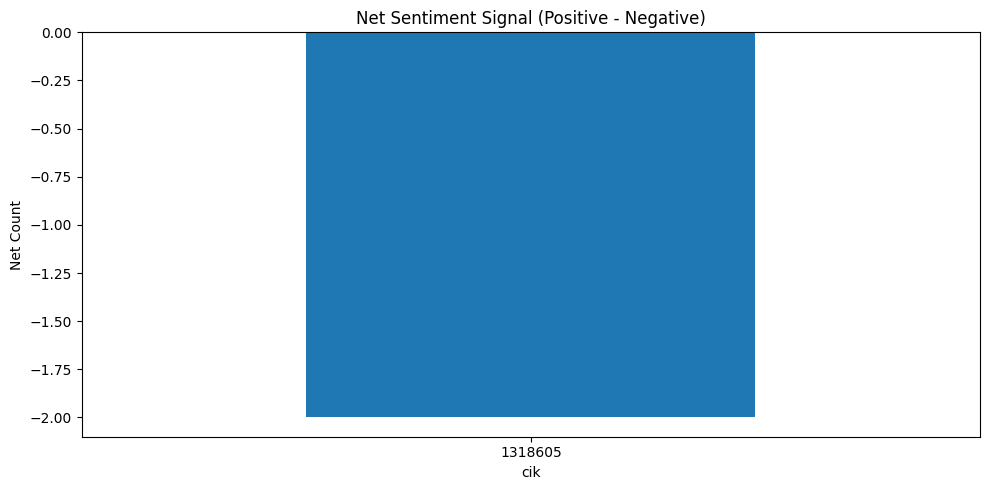

In [ ]:

# --- Step 8: Visualize sentiment summaries (basic keyword frequency) ---
summaries_df = pd.DataFrame(results)
summaries_df.set_index("cik", inplace=True)
sentiment_scores = summaries_df["summary"].apply(lambda s: s.lower().count("positive") - s.lower().count("negative"))
sentiment_scores.plot(kind="bar", title="Net Sentiment Signal (Positive - Negative)", ylabel="Net Count", figsize=(10,5), rot=0)
plt.tight_layout()
plt.show()
